In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('Integrated_Walmart_Dataset.csv')
df = df.sample(frac = 1, random_state = 41).reset_index(drop=True)

In [3]:
df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,MD1_present,MD2_present,MD3_present,MD4_present,MD5_present,A,B,C,IsHoliday_False,IsHoliday_True,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_15,Dept_16,Dept_17,Dept_18,Dept_19,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_39,Dept_40,Dept_41,Dept_42,Dept_43,Dept_44,Dept_45,Dept_46,Dept_47,Dept_48,Dept_49,Dept_50,Dept_51,Dept_52,Dept_53,Dept_54,Dept_55,Dept_56,Dept_57,Dept_58,Dept_59,Dept_60,Dept_61,Dept_62,Dept_63,Dept_64,Dept_65,Dept_66,Dept_67,Dept_68,Dept_69,Dept_70,Dept_71,Dept_72,Dept_73,Dept_74,Dept_75,Dept_76,Dept_77,Dept_78,Dept_79,Dept_80,Dept_81,BlackFriday_True,BlackFriday_False,ChristmasSoon_True,ChristmasSoon_False,ChristmasJustEnd_True,ChristmasJustEnd_False,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,Degree_cold,Degree_cool,Degree_hot,Degree_mild,Degree_warm,Median
0,6,58,2011-01-28,2426.00,0,44.98,3.010,0.0,0.0,0.0,0.0,0.0,213.714341,6.858,A,202505,False,False,False,False,False,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2820.00
1,5,23,2010-10-29,5543.01,0,70.58,2.716,0.0,0.0,0.0,0.0,0.0,212.464799,6.768,B,34875,False,False,False,False,False,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5741.98


### Split training, validation, testing

In [4]:
cut = int(0.6 * len(df))
df_train = df.iloc[0:cut]
df_rest  = df.iloc[cut:].reset_index(drop = True)

In [5]:
cut = int(0.5 * len(df_rest))
df_valid = df_rest.iloc[0:cut]
df_test  = df_rest.iloc[cut:].reset_index(drop = True)

In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)

(252942, 176) (84314, 176) (84314, 176)


### Oversampling training: Black Friday & Pre Christmas Days

In [7]:
df_bf = df_train[df_train['BlackFriday_True'] == 1].reset_index(drop = True)
repeat = 15
df_bf_oversampled = pd.concat([df_bf]*repeat).reset_index(drop = True)

In [8]:
df_chris = df_train[df_train['ChristmasSoon_True'] == 1].reset_index(drop = True)
repeat = 5
df_chris_oversampled = pd.concat([df_chris]*repeat).reset_index(drop = True)

In [9]:
df_bf.shape, df_chris.shape

((1792, 176), (10710, 176))

In [10]:
df_bf_oversampled.shape, df_chris_oversampled.shape

((26880, 176), (53550, 176))

In [11]:
17920 - 1792

16128

In [12]:
df_add_train = pd.concat([df_train, df_bf_oversampled, df_chris_oversampled], axis = 0).reset_index(drop = True)
df_add_train = df_add_train.sample(frac = 1, random_state = 41).reset_index(drop=True)
df_add_train.shape

(333372, 176)

### Input Pipeline

In [13]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [14]:
def return_tensor_dataset(df):
    df_x = df.drop(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Weekly_Sales',
                'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'Type', 'Size'], axis = 1).astype(float)
    
    df_y = df['Weekly_Sales'] - df_x['Median']
    
    X = df_x.to_numpy()
    y = df_y.to_numpy()
    
    x, med  = X[:, :-1], X[:, -1]
    
    tensor_dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1024).batch(526)
    
    return tensor_dataset, med, x, y

In [15]:
data_trn, med_trn, x_trn, y_trn = return_tensor_dataset(df_add_train)
data_val, med_val, x_val, y_val = return_tensor_dataset(df_valid)
data_tet, med_tet, x_tet, y_tet = return_tensor_dataset(df_test)

In [16]:
data_trn, data_val, data_tet

(<BatchDataset shapes: ((None, 162), (None,)), types: (tf.float64, tf.float64)>,
 <BatchDataset shapes: ((None, 162), (None,)), types: (tf.float64, tf.float64)>,
 <BatchDataset shapes: ((None, 162), (None,)), types: (tf.float64, tf.float64)>)

### Build Model

In [17]:
model = Sequential([layers.Input(shape = (162,)),
                    layers.Dense(64, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(16, activation = 'relu'),
                    layers.Dense(8, activation = 'relu'),
                    layers.Dense(1)])
model.compile(optimizer = 'adam', loss = 'mae')

trnmae = []
valmae = []

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                10432     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 14,241
Trainable params: 14,241
Non-trainable params: 0
____________________________________________________

In [19]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer = optimizer, loss = 'mae')
for epoch in range(5000):
    h = model.fit(data_trn, epochs = 1, validation_data = data_val, verbose = 0)
    trnmae.append(h.history['loss'][0])
    valmae.append(h.history['val_loss'][0])
    if epoch % 20 == 0:
        print('epoch: {}, trnmAe: {:.1f}, valmAe: {:.1f}'.format(epoch, trnmae[-1], valmae[-1]))
#     if valmae[-1] > valmae[-2]:
#         break
#         print('trnmAe: {:.1f}, valmAe: {:.1f}, trnmSe: {:.1f}, valmSe: {:.1f}'.format(trnmae[-1],
#                                                                                       valmae[-1],
#                                                                                       trnmse[-1],
#                                                                                       valmse[-1]))


epoch: 0, trnmAe: 3722.2, valmAe: 2362.0
epoch: 20, trnmAe: 2600.7, valmAe: 2233.3
epoch: 40, trnmAe: 2532.9, valmAe: 2198.2
epoch: 60, trnmAe: 2464.3, valmAe: 2167.2
epoch: 80, trnmAe: 2374.3, valmAe: 2116.0
epoch: 100, trnmAe: 2285.2, valmAe: 2051.2
epoch: 120, trnmAe: 2205.9, valmAe: 1977.6
epoch: 140, trnmAe: 2144.2, valmAe: 1936.0
epoch: 160, trnmAe: 2100.0, valmAe: 1906.8
epoch: 180, trnmAe: 2058.9, valmAe: 1879.6
epoch: 200, trnmAe: 2035.3, valmAe: 1870.4
epoch: 220, trnmAe: 2005.2, valmAe: 1849.6
epoch: 240, trnmAe: 1990.8, valmAe: 1844.9
epoch: 260, trnmAe: 1971.0, valmAe: 1830.6
epoch: 280, trnmAe: 1956.2, valmAe: 1827.4
epoch: 300, trnmAe: 1940.6, valmAe: 1818.8
epoch: 320, trnmAe: 1931.5, valmAe: 1807.7
epoch: 340, trnmAe: 1922.8, valmAe: 1809.0
epoch: 360, trnmAe: 1905.2, valmAe: 1793.3
epoch: 380, trnmAe: 1895.1, valmAe: 1795.6
epoch: 400, trnmAe: 1884.3, valmAe: 1793.2
epoch: 420, trnmAe: 1878.4, valmAe: 1790.1
epoch: 440, trnmAe: 1870.9, valmAe: 1790.3
epoch: 460, trnmA

epoch: 3760, trnmAe: 1584.4, valmAe: 1712.3
epoch: 3780, trnmAe: 1575.6, valmAe: 1707.8
epoch: 3800, trnmAe: 1571.3, valmAe: 1706.6
epoch: 3820, trnmAe: 1579.6, valmAe: 1712.6
epoch: 3840, trnmAe: 1578.3, valmAe: 1708.4
epoch: 3860, trnmAe: 1576.0, valmAe: 1707.4
epoch: 3880, trnmAe: 1577.2, valmAe: 1710.7
epoch: 3900, trnmAe: 1577.2, valmAe: 1705.3
epoch: 3920, trnmAe: 1581.6, valmAe: 1706.9
epoch: 3940, trnmAe: 1568.9, valmAe: 1713.3
epoch: 3960, trnmAe: 1573.0, valmAe: 1711.9
epoch: 3980, trnmAe: 1580.5, valmAe: 1712.5
epoch: 4000, trnmAe: 1580.6, valmAe: 1713.9
epoch: 4020, trnmAe: 1571.6, valmAe: 1713.1
epoch: 4040, trnmAe: 1575.3, valmAe: 1714.5
epoch: 4060, trnmAe: 1562.0, valmAe: 1710.4
epoch: 4080, trnmAe: 1568.9, valmAe: 1713.7
epoch: 4100, trnmAe: 1574.3, valmAe: 1708.7
epoch: 4120, trnmAe: 1569.5, valmAe: 1713.6
epoch: 4140, trnmAe: 1570.7, valmAe: 1711.8
epoch: 4160, trnmAe: 1566.4, valmAe: 1707.5
epoch: 4180, trnmAe: 1568.3, valmAe: 1712.2
epoch: 4200, trnmAe: 1567.9, val

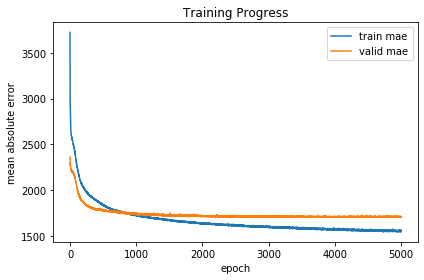

In [20]:
plt.plot(trnmae, label = 'train mae')
plt.plot(valmae, label = 'valid mae')
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.title('Training Progress')
plt.legend()
plt.tight_layout()

In [21]:
def show_result(x, y, median):
    pred = model.predict(x)
    
    m1 = np.min(np.c_[pred.ravel(), y.ravel()])
    m2 = np.max(np.c_[pred.ravel(), y.ravel()])

    plt.figure(figsize = (7, 7))
    y1 = y + median
    y2 = pred.squeeze() + median
    
    forcas_acc = np.mean(np.abs(y2 - y1)/(y1 + 1e-3))
    
    plt.scatter(y1, y2, s = 10)
    plt.xlim([m1, m2])
    plt.ylim([m1, m2])
    plt.xlabel('actual')
    plt.ylabel('prediction')
    
    return forcas_acc

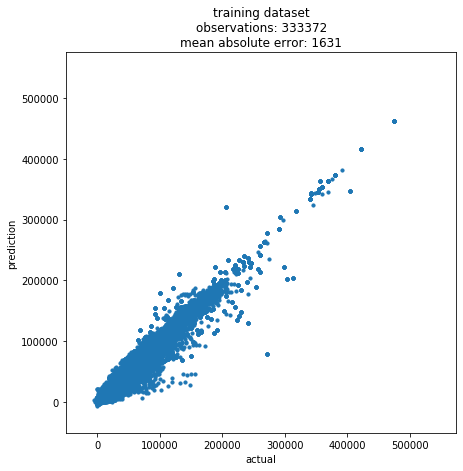

8.721780824322071


In [22]:
data, target, med = x_trn, y_trn, med_trn
mae = model.evaluate(data_trn, verbose = 0)
fca = show_result(x = data, y = target, median = med)
plt.title('training dataset\nobservations: {}\nmean absolute error: {:.0f}'.format(data.shape[0], mae))
plt.show()
print(fca)

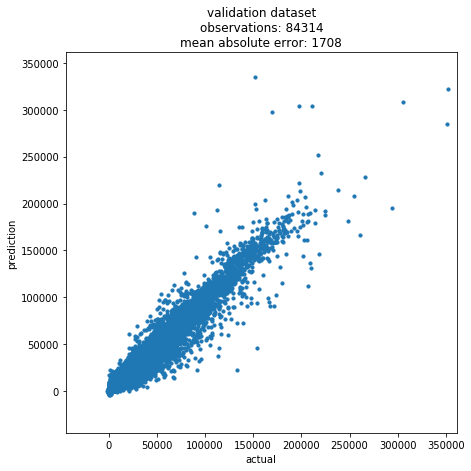

23.714252329315215


In [23]:
data, target, med = x_val, y_val, med_val
fca = show_result(x = data, y = target, median = med)
mae = model.evaluate(data_val, verbose = 0)
plt.title('validation dataset\nobservations: {}\nmean absolute error: {:.0f}'.format(data.shape[0], mae))
plt.show()
print(fca)

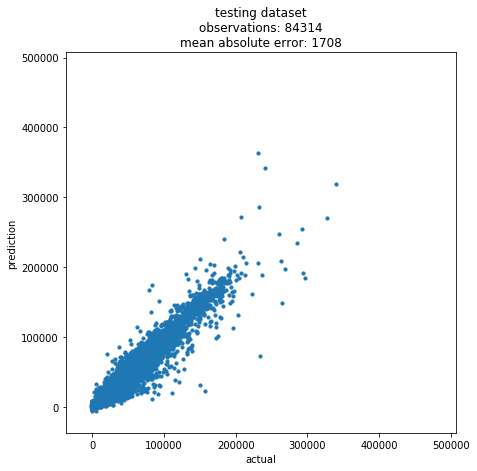

65.83281766298335


In [24]:
data, target, med = x_tet, y_tet, med_tet
mae = model.evaluate(data_tet, verbose = 0)
fca = show_result(x = data, y = target, median = med)
plt.title('testing dataset\nobservations: {}\nmean absolute error: {:.0f}'.format(data.shape[0], mae))
plt.show()
print(fca)